In [4]:
path = ""

In [3]:
import h5py

In [6]:
with h5py.File(path, "r") as f:
    print("Top-level keys:", list(f.keys()))
    # Example: read a dataset called 'X'
    if "X" in f:
        X = f["X"][()]   # NumPy array
        print(X.shape, X.dtype)

Top-level keys: ['#refs#', '#subsystem#', 'IsWatRef', 'NoiseCorrMatStruct', 'NoiseScalingMatrix_spectral', 'NoiseScalingMatrix_time', 'Par', 'csi', 'mask', 'weights']


In [1]:
import file

config_file_name = "paths_09012026.json"

configurator = file.Configurator(path_folder="../config/",
                                 file_name=config_file_name)
configurator.load()

In [38]:
import nibabel as nib
import numpy as np
import os

In [39]:
metabolite_map = nib.load(os.path.join(configurator.data["maps"]["metabolites_concentration"]["path"], "MetMap_Cr+PCr_con_map_TargetRes.nii"))
mask = nib.load(configurator.data["mask"]["metabolites"]["path"])

In [40]:
print(mask.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 112 128  80   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.     1.7188 1.7188 1.72   1.     0.     0.     0.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 1
glmin           : 0
descrip         : b'FSL4.0'
aux_file        : b'none'
qform_code      : unknown
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -94.534
qoffset_y       : -108.28439
qoffset_z       : -67.08

In [41]:
c1 = metabolite_map.header["srow_x"][:3]
c2 = metabolite_map.header["srow_y"][:3]
c3 = metabolite_map.header["srow_z"][:3]

print(c1)
print(c2)
print(c3)

[ 1.2193333  -0.05813259  0.06051305]
[0.05625402 1.2203125  0.03866627]
[-0.06236025 -0.03584902  1.2181034 ]


In [45]:
np.cross(c1, c2) /np.linalg.norm(np.cross(c1, c2))

array([-0.05093832, -0.02928265,  0.99827236], dtype=float32)

In [50]:
np.array([c1[2], c2[2], c3[2]]) / np.linalg.norm([c1[2], c2[2], c3[2]])

array([0.04959198, 0.03168799, 0.9982667 ], dtype=float32)

### normal_vector_slice = $\frac{c_3}{||c_3||_2}$


### 3D Affine Transformation Matrices:

Any combination of translation, rotations, scalings/reﬂections and shears can be combined in a single 4 by 4 afﬁne transformation matrix.

$$
\begin{bmatrix}
x\\
y\\
z\\
1
\end{bmatrix}
=
\begin{bmatrix}
 & & & t_x\\
 & A & & t_y\\
 & & & t_z\\
0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
i\\
j\\
k\\
1
\end{bmatrix}
$$

$$
\begin{bmatrix}
x\\
y\\
z\\
1
\end{bmatrix}
=
\begin{bmatrix}
a_{11} & a_{12} & a_{13} & t_x\\
a_{21} & a_{22} & a_{23} & t_y\\
a_{31} & a_{32} & a_{33} & t_z\\
0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
i\\
j\\
k\\
1
\end{bmatrix}
$$

* A = 3×3-Teil oben links (Rotation + Skalierung, evtl. Shear)
* $t=(t_x, t_y, t_z)$ = Translation (Position des Volumens im Raum)


$$
A\begin{bmatrix} i \\ j \\ k \end{bmatrix}
=
i\,A\begin{bmatrix} 1 \\ 0 \\ 0 \end{bmatrix}
+
j\,A\begin{bmatrix} 0 \\ 1 \\ 0 \end{bmatrix}
+
k\,A\begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix}
$$


## Die Vektoren

- $\left[1,0,0\right]^T$
- $\left[0,1,0\right]^T$
- $\left[0,0,1\right]^T$

sind die **Basisrichtungen im Voxelraum** $(i,j,k)$.

## Wenn ich im Volumen Slice zu Slice geeh, dann
$(i,j,k) \rightarrow (i,j,k+1)$ mit $(i,j)$ im slice bewegen und $k$ zwischen slices,

wobei die differenz ist

$(i,j,k +1) - (i,j,k) = (0,0,1)$

und somit der vektor

$\Delta v = \begin{bmatrix}0\\0\\1\end{bmatrix}$

und somit kommt man auf die Weltkoordinaten via:

$r(i,j,k) = A \begin{bmatrix}i\\j\\k\end{bmatrix}+ t$ $~~~~~\longrightarrow~~~~~~$ $r(i,j,k+1) = A \begin{bmatrix}i\\j\\k+1\end{bmatrix}+ t$

und die Differenz ergibt sich aus:

$\Delta r = A \Biggl( \begin{bmatrix}i\\j\\k+1\end{bmatrix} - \begin{bmatrix}i\\j\\k\end{bmatrix} \Biggr) = A \begin{bmatrix}0\\0\\1\end{bmatrix}$

und

$$
A\begin{bmatrix}0\\0\\1\end{bmatrix}
=
\begin{bmatrix}
a_{11}\cdot 0 + a_{12}\cdot 0 + a_{13}\cdot 1\\
a_{21}\cdot 0 + a_{22}\cdot 0 + a_{23}\cdot 1\\
a_{31}\cdot 0 + a_{32}\cdot 0 + a_{33}\cdot 1
\end{bmatrix}
=
\begin{bmatrix}
a_{13}\\
a_{23}\\
a_{33}
\end{bmatrix}
$$

In [51]:
np.array([c1[2], c2[2], c3[2]]) / np.linalg.norm([c1[2], c2[2], c3[2]])

array([0.04959198, 0.03168799, 0.9982667 ], dtype=float32)

In [ ]:
# Affine Matrix

#In NIfTI beschreibt die affine Matrix (4×4), wie man von Voxel-Koordinaten (i,j,k) zu Welt-/Scanner-Koordinaten (x,y,z) kommt.



In [2]:
import json
import os

In [4]:
with open('/home/mschuster/Synthetic_MRSI_PhD/Synthetic_MRSI/docs/chemical_compounds.json') as file:
    data = json.load(file)

In [11]:
for key in data["metabolites"].keys():
    print(key, data["metabolites"][key]["ppm"])

NAA [2.01]
Glu [3.75, 2.04, 2.35]
Gln [3.77, 2.12, 2.46, 6.8, 7.5]
m-Ins [3.53, 3.61, 3.27, 4.05]
Cr+PCr [3.03, 3.93]
GPC+PCh [3.21, 3.66, 4.31]


(0.0, 1.0)

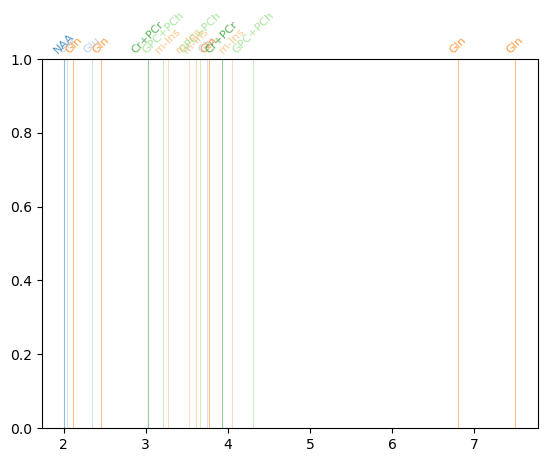

In [36]:
import matplotlib.pyplot as plt
import numpy as np

ax = plt.gca()  # or your existing axes

# Make a stable color per metabolite
metabs = list(data["metabolites"].keys())
cmap = plt.get_cmap("tab20")
color_map = {m: cmap(i % cmap.N) for i, m in enumerate(metabs)}

y0, y1 = ax.get_ylim()
ymin, ymax = (y0, y1) if y0 < y1 else (y1, y0)

for m in metabs:
    ppms = data["metabolites"][m]["ppm"]
    col = color_map[m]

    ax.vlines(ppms, ymin=ymin, ymax=ymax,
              colors=col, lw=0.8, alpha=0.5, zorder=0,
              label="_nolegend_")

    for x in ppms:
        ax.text(x, ymax+0.01, m, rotation=45, va="bottom", ha="center",
                color=col, alpha=0.8, fontsize=8, clip_on=False)

ax.set_ylim(0,1)

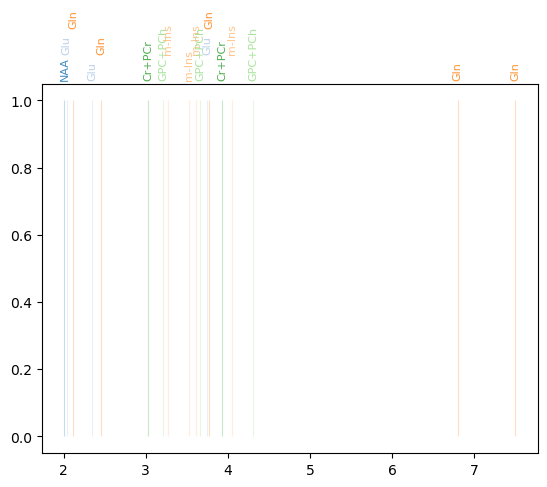

In [37]:
import matplotlib.pyplot as plt
import numpy as np

ax = plt.gca()

metabs = list(data["metabolites"].keys())
cmap = plt.get_cmap("tab20")
color_map = {m: cmap(i % cmap.N) for i, m in enumerate(metabs)}

# --- your vlines ---
y0, y1 = ax.get_ylim()
ymin, ymax = (y0, y1) if y0 < y1 else (y1, y0)

labels = []  # collect (x, text, kwargs)
for m in metabs:
    ppms = data["metabolites"][m]["ppm"]
    col = color_map[m]

    ax.vlines(ppms, ymin=ymin, ymax=ymax,
              colors=col, lw=0.8, alpha=0.25, zorder=0,
              label="_nolegend_")

    for x in ppms:
        labels.append((x, m, dict(color=col, alpha=0.85, fontsize=8,
                                  rotation=90, va="bottom", ha="center",
                                  clip_on=False)))

# --- collision-aware label stacking above the plot ---
fig = ax.figure
fig.canvas.draw()  # needed so transforms are correct

# how much x-distance corresponds to N pixels (controls spacing)
min_px = 10
inv = ax.transData.inverted()
dx = inv.transform((min_px, 0))[0] - inv.transform((0, 0))[0]

n_rows = 6                 # increase if you still see collisions
y_base = 1.01              # just above the axes
y_step = 0.07              # row spacing (in axes fraction)

last_x_in_row = [-np.inf] * n_rows

for x, txt, kw in sorted(labels, key=lambda t: t[0]):
    for r in range(n_rows):
        if x - last_x_in_row[r] >= dx:
            ax.text(x, y_base + r * y_step, txt,
                    transform=ax.get_xaxis_transform(),  # x in data, y in axes fraction
                    **kw)
            last_x_in_row[r] = x
            break
    # else: if no row fits, you can skip or force into last row; currently it just drops through

# If you want, keep your y-limits; labels won’t depend on them anymore
# ax.set_ylim(0, 1)

(1.4335499999999999, 8.07645)

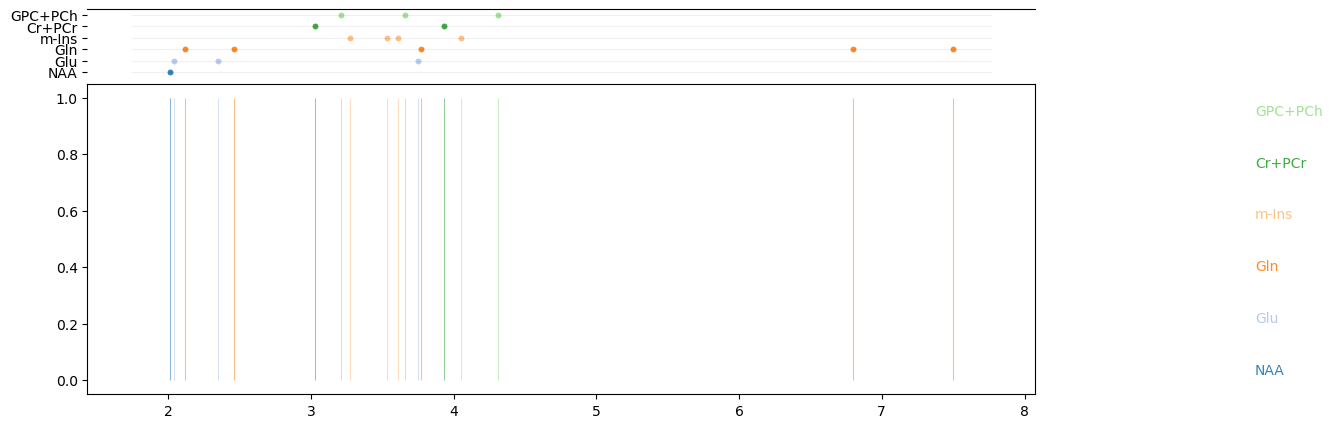

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=(15,5))

ax = plt.gca()

metabs = list(data["metabolites"].keys())
cmap = plt.get_cmap("tab20")
color_map = {m: cmap(i % cmap.N) for i, m in enumerate(metabs)}

# --- main plot: light vlines (optional but nice) ---
y0, y1 = ax.get_ylim()
ymin, ymax = (y0, y1) if y0 < y1 else (y1, y0)

for m in metabs:
    ppms = data["metabolites"][m]["ppm"]
    ax.vlines(ppms, ymin=ymin, ymax=ymax,
              colors=color_map[m], lw=0.8, alpha=0.50, zorder=0,
              label="_nolegend_")

# --- layout: add a top axis (dots track) + right axis (name list) ---
divider = make_axes_locatable(ax)
ax_top   = divider.append_axes("top",   size="22%", pad=0.06, sharex=ax)
ax_right = divider.append_axes("right", size="22%", pad=0.06, sharey=ax_top)

# Top axis: metabolite rows
n = len(metabs)
ax_top.set_ylim(-0.5, n - 0.5)
ax_top.set_yticks([])  # no y ticks here
ax_top.tick_params(axis="x", which="both", bottom=False, labelbottom=False, top=False, labeltop=False)
for s in ["left", "right", "bottom"]:
    ax_top.spines[s].set_visible(False)

# Right axis: list of metabolite names aligned to rows
ax_right.set_xlim(0, 1)
ax_right.set_xticks([])
ax_right.set_yticks(range(n))
ax_right.set_yticklabels(metabs)
ax_right.yaxis.tick_right()
ax_right.tick_params(axis="y", length=0)  # no tick marks
for s in ["top", "bottom", "left", "right"]:
    ax_right.spines[s].set_visible(False)

# Color each name to match its metabolite
for tick, m in zip(ax_right.get_yticklabels(), metabs):
    tick.set_color(color_map[m])
    tick.set_alpha(0.9)

# --- dots in the top track: one row per metabolite, dots at ppm positions ---
for i, m in enumerate(metabs):
    ppms = np.asarray(data["metabolites"][m]["ppm"], dtype=float)
    y = np.full_like(ppms, i, dtype=float)
    ax_top.scatter(ppms, y, s=18, color=color_map[m], alpha=0.9, linewidths=0)

# Optional: light horizontal guides per metabolite row (in the top track)
ax_top.hlines(np.arange(n), xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
              colors="k", alpha=0.06, lw=0.8)

# keep xlims synced
ax_top.set_xlim(ax.get_xlim())

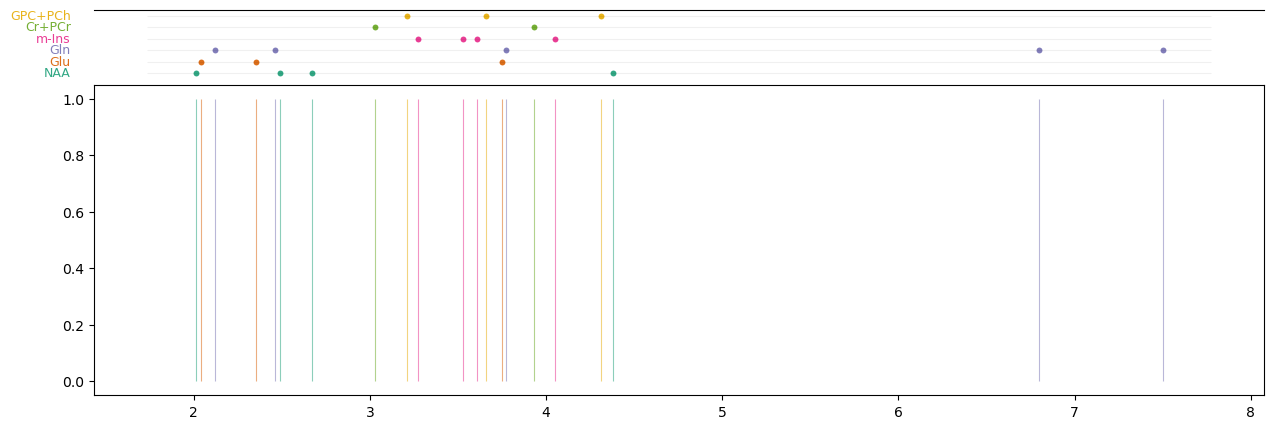

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.transforms import blended_transform_factory

plt.figure(figsize=(15,5))
ax = plt.gca()

metabs = list(data["metabolites"].keys())
cmap = plt.get_cmap("Dark2")
color_map = {m: cmap(i % cmap.N) for i, m in enumerate(metabs)}

# --- main plot: vlines ---
y0, y1 = ax.get_ylim()
ymin, ymax = (y0, y1) if y0 < y1 else (y1, y0)

for m in metabs:
    ppms = data["metabolites"][m]["ppm"]
    ax.vlines(ppms, ymin=ymin, ymax=ymax,
              colors=color_map[m], lw=0.8, alpha=0.50, zorder=0,
              label="_nolegend_")

# --- layout: add only top axis ---
divider = make_axes_locatable(ax)
ax_top = divider.append_axes("top", size="22%", pad=0.06, sharex=ax)

# Top axis: metabolite rows
n = len(metabs)
ax_top.set_ylim(-0.5, n - 0.5)
ax_top.set_yticks([])
ax_top.tick_params(axis="x", which="both", bottom=False, labelbottom=False, top=False, labeltop=False)
for s in ["left", "right", "bottom"]:
    ax_top.spines[s].set_visible(False)

# --- dots in the top track + names on top-left ---
# blended: x in axes coords (0..1), y in data coords (row index)
trans = blended_transform_factory(ax_top.transAxes, ax_top.transData)

for i, m in enumerate(metabs):
    col = color_map[m]
    ppms = np.asarray(data["metabolites"][m]["ppm"], dtype=float)

    # dots at ppm positions in row i
    ax_top.scatter(ppms, np.full_like(ppms, i, dtype=float),
                   s=18, color=col, alpha=0.9, linewidths=0)

    # name on the left of the top axis (top-left list)
    ax_top.text(-0.02, i, m, transform=trans,  # negative x pushes it left of the axis
                ha="right", va="center", color=col, alpha=0.9, fontsize=9,
                clip_on=False)

# Optional: light horizontal guides per metabolite row (in the top track)
ax_top.hlines(np.arange(n), xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
              colors="k", alpha=0.06, lw=0.8)

ax_top.set_xlim(ax.get_xlim())

# give a bit more left margin so the names aren’t cut off
plt.gcf().subplots_adjust(left=0.12)

In [6]:
metab_dict = {}

for key in data["metabolites"].keys():
    metab_dict[key] = data["metabolites"][key]["ppm"]

In [7]:
metab_dict

{'NAA': [2.01, 2.49, 2.67, 4.38],
 'Glu': [3.75, 2.04, 2.35],
 'Gln': [3.77, 2.12, 2.46, 6.8, 7.5],
 'm-Ins': [3.53, 3.61, 3.27, 4.05],
 'Cr+PCr': [3.03, 3.93],
 'GPC+PCh': [3.21, 3.66, 4.31]}

In [21]:
from pathlib import Path
import json

path = Path.cwd().parent / "docs" / "chemical_compounds.json"


In [13]:
with path.open("r", encoding="utf-8") as f:
    compounds = json.load(f)

In [14]:
compounds

{'Author': 'Markus Schuster',
 'Description': 'This file contains mainly the parts per million (ppm) information about chemical compounds for 1H-MRS (e.g., metabolites) and some additional information.',
 'version': '2026-02-27',
 'references': 'docs/references.bib',
 'metabolites': {'NAA': {'name_full': 'N-acetylaspartate',
   'ppm': [2.01, 2.49, 2.67, 4.38, 7.82],
   'concentration': {'deGraaf': {'GM': {'range': [8, 10], 'unit': 'mM'},
     'WM': {'range': [6, 9], 'unit': 'mM'}},
    'Pouwels': {'WM': {'frontal': {'range': [7.2, 9.0], 'unit': 'mM'},
      'parietal': {'range': [7.0, 9.0], 'unit': 'mM'},
      'occipital': {'range': [6.9, 8.7], 'unit': 'mM'}},
     'GM': {'frontal': {'range': [6.7, 8.7], 'unit': 'mM'},
      'parietal': {'range': [7.4, 9.0], 'unit': 'mM'},
      'occipital': {'range': [8.3, 10.1], 'unit': 'mM'},
      'insular': {'range': [7.9, 9.5], 'unit': 'mM'}}}},
   'biosignificance': 'the exact function remains largely unknown; suggested functions are: osmoregul

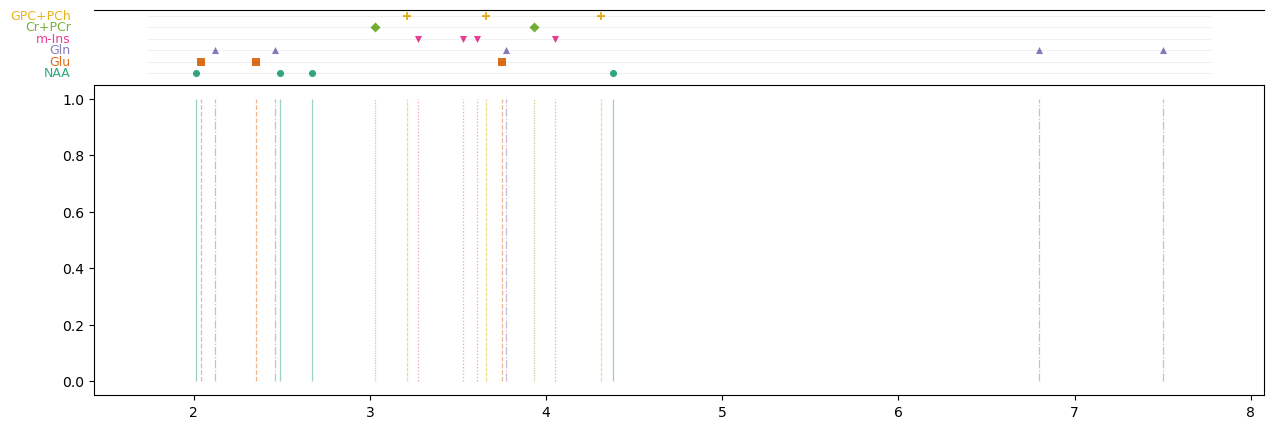

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.transforms import blended_transform_factory

plt.figure(figsize=(15, 5))
ax = plt.gca()

metabs = list(data["metabolites"].keys())

# --- colors ---
cmap = plt.get_cmap("Dark2")
color_map = {m: cmap(i % cmap.N) for i, m in enumerate(metabs)}

# --- NEW: linestyles + markers (cycled per metabolite) ---
linestyle_list = [
    "-", "--", "-.", ":",
    (0, (1, 1)),          # dense dots
    (0, (3, 1)),          # short dashes
    (0, (5, 2)),          # medium dashes
    (0, (7, 2)),          # long dashes
    (0, (3, 1, 1, 1)),    # dash-dot (custom)
    (0, (5, 1, 1, 1)),    # longer dash-dot
]
marker_list = ["o", "s", "^", "v", "D", "P", "X", "*", "+", "x", "<", ">"]

ls_cycle = itertools.cycle(linestyle_list)
mk_cycle = itertools.cycle(marker_list)
linestyle_map = {m: next(ls_cycle) for m in metabs}
marker_map = {m: next(mk_cycle) for m in metabs}

# --- main plot: vlines ---
y0, y1 = ax.get_ylim()
ymin, ymax = (y0, y1) if y0 < y1 else (y1, y0)

for m in metabs:
    ppms = np.asarray(data["metabolites"][m]["ppm"], dtype=float)
    ppms = ppms[np.isfinite(ppms)]
    if ppms.size == 0:
        continue

    ax.vlines(
        ppms, ymin=ymin, ymax=ymax,
        colors=color_map[m],
        linestyles=linestyle_map[m],   # NEW
        lw=0.9,
        alpha=0.45,
        zorder=0,
        label="_nolegend_",
    )

# --- layout: add only top axis ---
divider = make_axes_locatable(ax)
ax_top = divider.append_axes("top", size="22%", pad=0.06, sharex=ax)

# Top axis: metabolite rows
n = len(metabs)
ax_top.set_ylim(-0.5, n - 0.5)
ax_top.set_yticks([])
ax_top.tick_params(axis="x", which="both", bottom=False, labelbottom=False, top=False, labeltop=False)
for s in ["left", "right", "bottom"]:
    ax_top.spines[s].set_visible(False)

# --- dots in the top track + names on top-left ---
# blended: x in axes coords (0..1), y in data coords (row index)
trans = blended_transform_factory(ax_top.transAxes, ax_top.transData)

for i, m in enumerate(metabs):
    col = color_map[m]
    ppms = np.asarray(data["metabolites"][m]["ppm"], dtype=float)
    ppms = ppms[np.isfinite(ppms)]
    if ppms.size == 0:
        continue

    # dots at ppm positions in row i
    ax_top.scatter(
        ppms,
        np.full_like(ppms, i, dtype=float),
        s=26,
        color=col,
        marker=marker_map[m],          # NEW
        alpha=0.9,
        linewidths=0,
    )

    # name on the left of the top axis (top-left list)
    ax_top.text(
        -0.02, i, m, transform=trans,
        ha="right", va="center",
        color=col, alpha=0.9, fontsize=9,
        clip_on=False,
    )

# Optional: light horizontal guides per metabolite row (in the top track)
ax_top.hlines(
    np.arange(n),
    xmin=ax.get_xlim()[0],
    xmax=ax.get_xlim()[1],
    colors="k",
    alpha=0.06,
    lw=0.8,
)

ax_top.set_xlim(ax.get_xlim())

# give a bit more left margin so the names aren’t cut off
plt.gcf().subplots_adjust(left=0.12)